In [1]:
import pickle
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stat
import time
%matplotlib inline

from sklearn.metrics import accuracy_score

from nilearn.connectome import ConnectivityMeasure

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score

import networkx as nx
import torch
import torch_geometric.utils
from torch_geometric.data import Data, DataLoader
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool

from sklearn import svm

import pickle5 as pickle
import os

from typing import Optional, Tuple
from torch_geometric.typing import Adj, OptTensor, PairTensor

# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
import torch
from torch import Tensor
from torch.nn import Parameter
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, matmul, fill_diag, sum as sparsesum, mul
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes
from torch import softmax

In [2]:
def load_obj(path):
    with open(path + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
AD_dict = load_obj('AAL_data/timeseries/AD')
CN_dict = load_obj('AAL_data/timeseries/CN')

AD_train = load_obj('AAL_data/AD_train_full')
AD_val = load_obj('AAL_data/AD_val_full')
AD_test = load_obj('AAL_data/AD_test_full')

CN_train = load_obj('AAL_data/CN_train_full')
CN_val = load_obj('AAL_data/CN_val_full')
CN_test = load_obj('AAL_data/CN_test_full')

In [4]:
def get_correlation_matrix(timeseries,msr):
    correlation_measure = ConnectivityMeasure(kind=msr)
    correlation_matrix = correlation_measure.fit_transform([timeseries])[0]
    return correlation_matrix

def get_upper_triangular_matrix(matrix):
    upp_mat = []
    for i in range(len(matrix)):
        for j in range(i+1,len(matrix)):
            upp_mat.append(matrix[i][j])
    return upp_mat

    
# def get_adj_mat(correlation_matrix, threshold_value, weighted = True):
#     adj_mat = []
#     for i in correlation_matrix:
#         row = []
#         for j in i:
#             if abs(j)>threshold_value:
#                 if not weighted:
#                     row.append(1)
#                 else:
#                     row.append(abs(j))
#             else:
#                 row.append(0)
#         adj_mat.append(row)
#     return adj_mat


def get_adj_mat(correlation_matrix, th_value_p, th_value_n):
    adj_mat = []
    k=0
    for i in correlation_matrix:
        row = []
        for j in i:
            if j>0:
                if j > th_value_p:
                    row.append(j)
                else:
                    row.append(0)
            else:
                if abs(j) > th_value_n:
                    row.append(abs(j))
                else:
                    row.append(0)
        adj_mat.append(row)
#     adj_mat = connect_isolated_nodes(adj_mat, correlation_matrix)
    return adj_mat


def connect_isolated_nodes(adj_mat, correlation_matrix):
    correlation_matrix = list(np.array(correlation_matrix) - np.array(np.eye(len(correlation_matrix))))
    correlation_matrix = [list(a) for a in correlation_matrix]
                              
    for row_num in range(len(adj_mat)):
        if sum(adj_mat[row_num]) == 0:
            index_max_element_corr_row = correlation_matrix[row_num].index(max(correlation_matrix[row_num]))
            adj_mat[row_num][index_max_element_corr_row] = 1
    return adj_mat
    
# def get_threshold_value(ad_timeseires, cn_timeseries, measure, threshold_percent):
#     ad_corr_mats = [get_correlation_matrix(ts, measure) for ts in ad_timeseires]
#     cn_corr_mats = [get_correlation_matrix(ts, measure) for ts in cn_timeseries]

#     ad_upper = [get_upper_triangular_matrix(matrix) for matrix in ad_corr_mats]
#     cn_upper = [get_upper_triangular_matrix(matrix) for matrix in cn_corr_mats]

#     all_correlation_values = ad_upper + cn_upper
#     all_correlation_values = np.array(all_correlation_values).flatten()

#     all_correlation_values = np.array([abs(i) for i in all_correlation_values])
#     all_correlation_values = np.sort(all_correlation_values)[::-1]

#     th_val_index = (len(all_correlation_values)*threshold_percent)//100
#     return all_correlation_values[int(th_val_index)]


def get_threshold_value(ad_timeseires, cn_timeseries, measure, threshold_percent):
    ad_corr_mats = [get_correlation_matrix(ts, measure) for ts in ad_timeseires]
    cn_corr_mats = [get_correlation_matrix(ts, measure) for ts in cn_timeseries]

    ad_upper = [get_upper_triangular_matrix(matrix) for matrix in ad_corr_mats]
    cn_upper = [get_upper_triangular_matrix(matrix) for matrix in cn_corr_mats]

    all_correlation_values = ad_upper + cn_upper
    all_correlation_values = np.array(all_correlation_values).flatten()
    
    all_correlation_values_pos=[]
    all_correlation_values_neg=[]
    for i in all_correlation_values:
        if i==1:
            continue
        elif i>0:
            all_correlation_values_pos.append(i)
        else:  
            all_correlation_values_neg.append(abs(i))

    all_correlation_values_pos = np.array(all_correlation_values_pos)
    all_correlation_values_pos = np.sort(all_correlation_values_pos)[::-1]
    
    all_correlation_values_neg = np.array(all_correlation_values_neg)
    all_correlation_values_neg = np.sort(all_correlation_values_neg)[::-1]

    th_val_index = (len(all_correlation_values)*threshold_percent)//100
    
    return all_correlation_values_pos[int(th_val_index)], all_correlation_values_neg[int(th_val_index)]

def create_graph(timeseries, y, measure='correlation'):
    correlation_matrix = get_correlation_matrix(timeseries, measure)
    adj_mat = np.abs(correlation_matrix)

    G = nx.from_numpy_matrix(np.array(adj_mat), create_using=nx.DiGraph)
    data=torch_geometric.utils.from_networkx(G)
    data['x'] = torch.tensor(correlation_matrix, dtype=torch.float)
    data['y'] = torch.tensor([y])

    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        data = data.to(device)
        return data
  
    return data

In [10]:
num_classes = 2

class GAT(torch.nn.Module):
    def __init__(self, dim1, num_hidden_channels, hidden_channels_dims):
        super(GAT, self).__init__()
        torch.manual_seed(0)
        self.num_hidden_channels = num_hidden_channels
        self.hidden_channels_dims = hidden_channels_dims
        self.conv1 = GATConv(dim1, hidden_channels_dims[0])
        self.conv2 = GATConv(hidden_channels_dims[0], hidden_channels_dims[1])
#         self.conv3 = GATConv(hidden_channels_dims[1], hidden_channels_dims[2])
        self.lin1 = Linear(hidden_channels_dims[-1], 2)

    def forward(self, x1, edge_index1, edge_weight1, batch1):

        x1= self.conv1(x1, edge_index1)
        x1 = x1.relu()
#         x1 = x1.tanh()
        x1 = F.dropout(x1, p=0.5, training=self.training)
        
        x1 = self.conv2(x1, edge_index1)
        x1 = x1.relu()
#         x1 = x1.tanh()
        x1 = F.dropout(x1, p=0.5, training=self.training)
        
#         x1 = self.conv3(x1, edge_index1)
#         x1 = x1.relu()
# #         x1 = x1.tanh()
#         x1 = F.dropout(x1, p=0.5, training=self.training)

        x1 = global_mean_pool(x1, batch1)
        x1 = self.lin1(x1)

        return x1

In [11]:
class EarlyStopping:
    """Early stops the training if validation acc doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation acc improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation acc improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_acc_max = 0
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_acc, model):

        score = val_acc

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_acc, model)
            self.counter = 0

    def save_checkpoint(self, val_acc, model):
        '''Saves model when validation acc increase.'''
        if self.verbose:
            self.trace_func(f'Validation acc increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_acc_max = val_acc

In [12]:
def train(model):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.weight, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

def test(test_loader):
    model.eval()

    correct = 0
    for data in test_loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.weight, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  
    return correct / len(test_loader.dataset)

def f1(loader):
    model.eval()

    y_true = []
    y_pred = []

    for data in loader:
        out = model(data.x, data.edge_index, data.weight, data.batch)
        pred = out.argmax(dim=1)
        y_pred += pred.cpu().detach().tolist()
        y_true += data.y.cpu().detach().tolist()

    return f1_score(y_true,y_pred)

In [13]:
model = GAT(dim1 = 116, num_hidden_channels = 2, hidden_channels_dims = [32, 16])
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GAT(
  (conv1): GATConv(116, 32, heads=1)
  (conv2): GATConv(32, 16, heads=1)
  (lin1): Linear(in_features=16, out_features=2, bias=True)
)
Number of parameters:  4402


Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.031746).  Saving model ...
Validation acc increased (0.031746 --> 0.583333).  Saving model ...
Validation acc increased (0.583333 --> 0.634615).  Saving model ...
Validation acc increased (0.634615 --> 0.647619).  Saving model ...
Validation acc increased (0.647619 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.714286).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.714286 --> 0.736842).  Saving model ...
Validation acc increased (0.736842 --> 0.800000).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.800000 --> 0.829268).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200


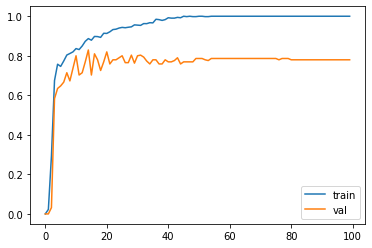

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.129032).  Saving model ...
Validation acc increased (0.129032 --> 0.602151).  Saving model ...
Validation acc increased (0.602151 --> 0.699029).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.699029 --> 0.728972).  Saving model ...
Validation acc increased (0.728972 --> 0.747664).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.747664 --> 0.785714).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.785714 --> 0.803571).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.803571 --> 0.814159).  Saving model ...
EarlyStopping counter: 1 out of 

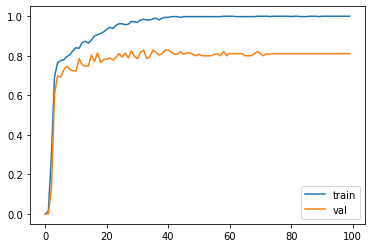

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.156250).  Saving model ...
Validation acc increased (0.156250 --> 0.637363).  Saving model ...
Validation acc increased (0.637363 --> 0.707071).  Saving model ...
Validation acc increased (0.707071 --> 0.730769).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.730769 --> 0.759259).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.759259 --> 0.810811).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.810811 --> 0.814159).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.814159 --> 0.814159).  Saving model ...
Validation acc increased (0.814159 --> 0.814159).  Saving model ...
EarlyStopping counter: 1 out of 200


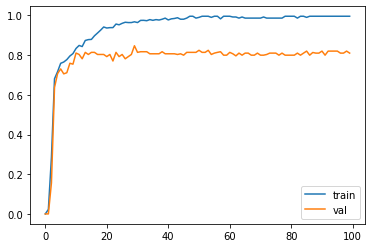

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.179104).  Saving model ...
Validation acc increased (0.179104 --> 0.618557).  Saving model ...
Validation acc increased (0.618557 --> 0.698113).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.698113 --> 0.725664).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.725664 --> 0.736842).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.736842 --> 0.779661).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.779661 --> 0.803279).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out

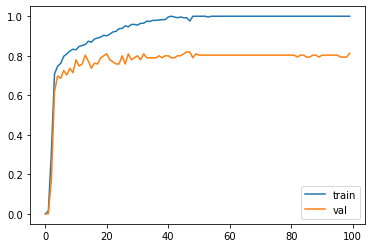

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.281690).  Saving model ...
Validation acc increased (0.281690 --> 0.631579).  Saving model ...
Validation acc increased (0.631579 --> 0.673267).  Saving model ...
Validation acc increased (0.673267 --> 0.685714).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.685714 --> 0.698113).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.698113 --> 0.710280).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
Validation acc increased (0.710280 --> 0.722222).  Saving mo

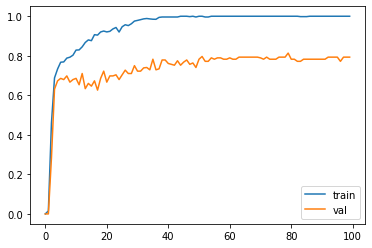

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033333).  Saving model ...
Validation acc increased (0.033333 --> 0.488372).  Saving model ...
Validation acc increased (0.488372 --> 0.580645).  Saving model ...
Validation acc increased (0.580645 --> 0.633663).  Saving model ...
Validation acc increased (0.633663 --> 0.678899).  Saving model ...
Validation acc increased (0.678899 --> 0.678899).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.678899 --> 0.732143).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.732143 --> 0.733945).  Saving model ...
Validation acc increased (0.733945 --> 0.758621).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200


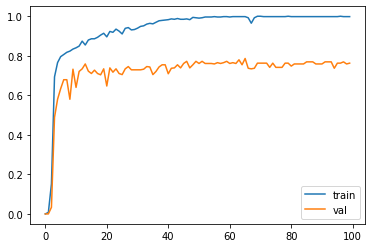

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.066667).  Saving model ...
Validation acc increased (0.066667 --> 0.444444).  Saving model ...
Validation acc increased (0.444444 --> 0.602151).  Saving model ...
Validation acc increased (0.602151 --> 0.673077).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.673077 --> 0.727273).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.727273 --> 0.738739).  Saving model ...
Validation acc increased (0.738739 --> 0.743363).  Saving model ...
Validation acc increased (0.743363 --> 0.786325).  Saving model ...
Validation acc increased (0.786325 --> 0.796610).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.796610 --> 0.810345).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Vali

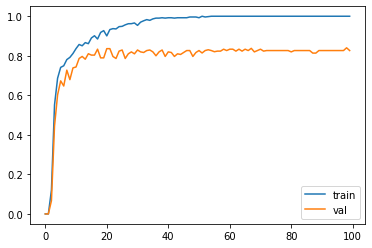

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.095238).  Saving model ...
Validation acc increased (0.095238 --> 0.539326).  Saving model ...
Validation acc increased (0.539326 --> 0.632653).  Saving model ...
Validation acc increased (0.632653 --> 0.698113).  Saving model ...
Validation acc increased (0.698113 --> 0.698113).  Saving model ...
Validation acc increased (0.698113 --> 0.709091).  Saving model ...
Validation acc increased (0.709091 --> 0.743363).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.743363 --> 0.743363).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.743363 --> 0.750000).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200


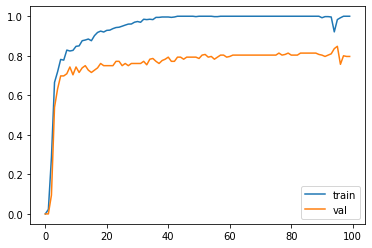

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.273973).  Saving model ...
Validation acc increased (0.273973 --> 0.623656).  Saving model ...
Validation acc increased (0.623656 --> 0.673267).  Saving model ...
Validation acc increased (0.673267 --> 0.738739).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.738739 --> 0.750000).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.750000 --> 0.773109).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.773109 --> 0.789916).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out

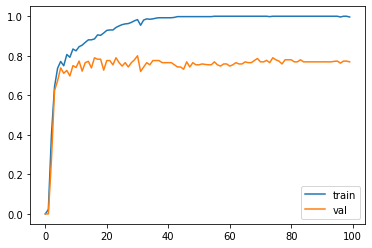

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.092308).  Saving model ...
Validation acc increased (0.092308 --> 0.516854).  Saving model ...
Validation acc increased (0.516854 --> 0.516854).  Saving model ...
Validation acc increased (0.516854 --> 0.618557).  Saving model ...
Validation acc increased (0.618557 --> 0.728972).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out of 200
EarlyStopping counter: 9 out of 200
EarlyStopping counter: 10 out of 200
EarlyStopping counter: 11 out of 200
EarlyStopping counter: 12 out of 200
EarlyStopping counter: 13 out of 200
Validation acc increased (0.728972 --> 0.752294).  S

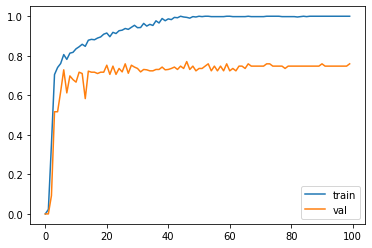

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.034483).  Saving model ...
Validation acc increased (0.034483 --> 0.363636).  Saving model ...
Validation acc increased (0.363636 --> 0.699029).  Saving model ...
Validation acc increased (0.699029 --> 0.711538).  Saving model ...
Validation acc increased (0.711538 --> 0.738739).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.738739 --> 0.738739).  Saving model ...
Validation acc increased (0.738739 --> 0.761062).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.761062 --> 0.761062).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.761062 --> 0.782609).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.7826

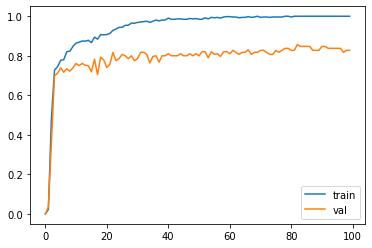

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.260870).  Saving model ...
Validation acc increased (0.260870 --> 0.680412).  Saving model ...
Validation acc increased (0.680412 --> 0.716981).  Saving model ...
Validation acc increased (0.716981 --> 0.722222).  Saving model ...
Validation acc increased (0.722222 --> 0.727273).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.727273 --> 0.745455).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.745455 --> 0.785714).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.785714 --> 0.800000).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.800000 --> 0.807018).  Saving model ...
Validation acc increased (0.807018 --> 0.807018).  Saving model ...
Earl

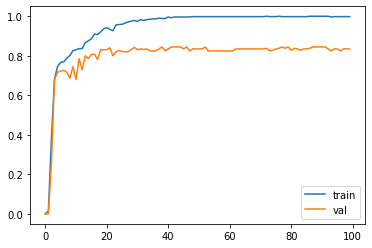

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.093750).  Saving model ...
Validation acc increased (0.093750 --> 0.561798).  Saving model ...
Validation acc increased (0.561798 --> 0.626263).  Saving model ...
Validation acc increased (0.626263 --> 0.691589).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.691589 --> 0.710280).  Saving model ...
Validation acc increased (0.710280 --> 0.710280).  Saving model ...
Validation acc increased (0.710280 --> 0.715596).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.715596 --> 0.727273).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.727273 --> 0.743363).  Saving model ...
Validation acc increased (0.743363 --> 0.743363).  Saving model ...
EarlyStopping counter: 1 out of 200
Earl

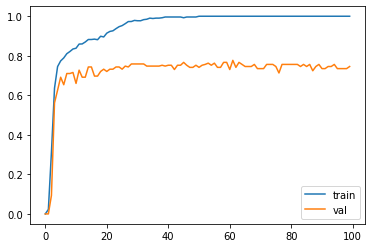

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.066667).  Saving model ...
Validation acc increased (0.066667 --> 0.554217).  Saving model ...
Validation acc increased (0.554217 --> 0.639175).  Saving model ...
Validation acc increased (0.639175 --> 0.685714).  Saving model ...
Validation acc increased (0.685714 --> 0.692308).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.692308 --> 0.752294).  Saving model ...
Validation acc increased (0.752294 --> 0.754386).  Saving model ...
Validation acc increased (0.754386 --> 0.756757).  Saving model ...
Validation acc increased (0.756757 --> 0.785714).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.785714 -

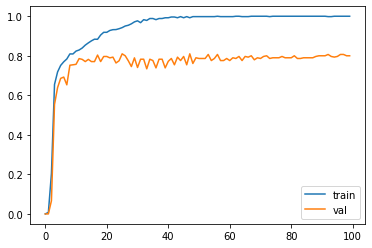

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.212121).  Saving model ...
Validation acc increased (0.212121 --> 0.659574).  Saving model ...
Validation acc increased (0.659574 --> 0.673267).  Saving model ...
Validation acc increased (0.673267 --> 0.704762).  Saving model ...
Validation acc increased (0.704762 --> 0.722222).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.722222 --> 0.767857).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.767857 --> 0.793103).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.793103 --> 0.803419).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 

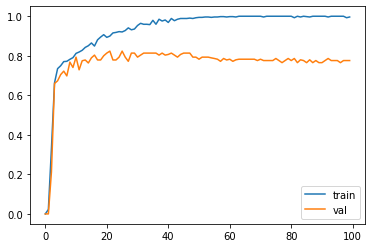

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.208955).  Saving model ...
Validation acc increased (0.208955 --> 0.593407).  Saving model ...
Validation acc increased (0.593407 --> 0.621359).  Saving model ...
Validation acc increased (0.621359 --> 0.621359).  Saving model ...
Validation acc increased (0.621359 --> 0.628571).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.628571 --> 0.635514).  Saving model ...
Validation acc increased (0.635514 --> 0.648649).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.648649 --> 0.666667).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.666667 --> 0.741379).  Saving model ...


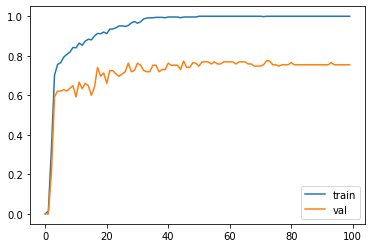

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.200000).  Saving model ...
Validation acc increased (0.200000 --> 0.511111).  Saving model ...
Validation acc increased (0.511111 --> 0.543478).  Saving model ...
Validation acc increased (0.543478 --> 0.568421).  Saving model ...
Validation acc increased (0.568421 --> 0.660377).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.660377 --> 0.672897).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.672897 --> 0.685185).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.685185 --> 0.685185).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.6851

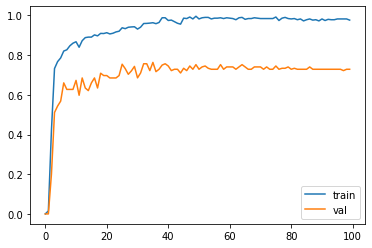

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.156250).  Saving model ...
Validation acc increased (0.156250 --> 0.577778).  Saving model ...
Validation acc increased (0.577778 --> 0.685185).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.685185 --> 0.692308).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.692308 --> 0.715596).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.715596 --> 0.728972).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7

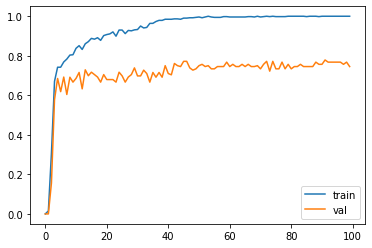

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.181818).  Saving model ...
Validation acc increased (0.181818 --> 0.595745).  Saving model ...
Validation acc increased (0.595745 --> 0.673077).  Saving model ...
Validation acc increased (0.673077 --> 0.722222).  Saving model ...
Validation acc increased (0.722222 --> 0.728972).  Saving model ...
Validation acc increased (0.728972 --> 0.728972).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.728972 --> 0.756757).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.756757 --> 0.786325).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.786325 --> 0.820513).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200


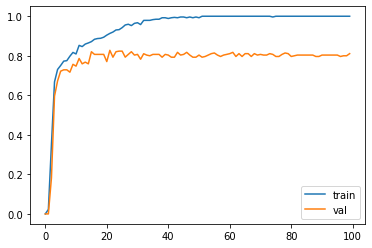

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.505747).  Saving model ...
Validation acc increased (0.505747 --> 0.618557).  Saving model ...
Validation acc increased (0.618557 --> 0.640000).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.640000 --> 0.738739).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.738739 --> 0.782609).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.782609 --> 0.789474).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out

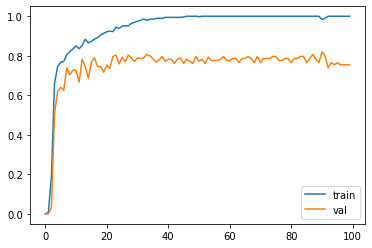

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.125000).  Saving model ...
Validation acc increased (0.125000 --> 0.580645).  Saving model ...
Validation acc increased (0.580645 --> 0.660000).  Saving model ...
Validation acc increased (0.660000 --> 0.673267).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.673267 --> 0.692308).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.692308 --> 0.714286).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7

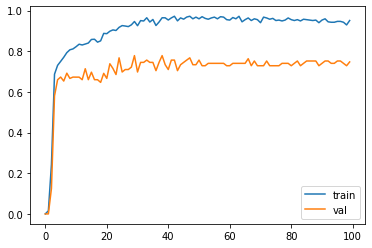

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.126984).  Saving model ...
Validation acc increased (0.126984 --> 0.511628).  Saving model ...
Validation acc increased (0.511628 --> 0.618557).  Saving model ...
Validation acc increased (0.618557 --> 0.699029).  Saving model ...
Validation acc increased (0.699029 --> 0.716981).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.716981 --> 0.782609).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.782609 --> 0.796610).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out

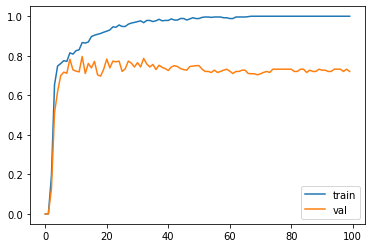

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.129032).  Saving model ...
Validation acc increased (0.129032 --> 0.577778).  Saving model ...
Validation acc increased (0.577778 --> 0.646465).  Saving model ...
Validation acc increased (0.646465 --> 0.679612).  Saving model ...
Validation acc increased (0.679612 --> 0.697248).  Saving model ...
Validation acc increased (0.697248 --> 0.720721).  Saving model ...
Validation acc increased (0.720721 --> 0.725664).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.725664 --> 0.725664).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.725664 --> 0.727273).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.727273 --> 0.727273).  Saving model ...
Validation acc increased (0.727273 --> 0.738739).  Saving model ...
EarlySto

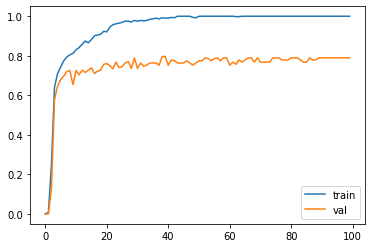

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.208955).  Saving model ...
Validation acc increased (0.208955 --> 0.602151).  Saving model ...
Validation acc increased (0.602151 --> 0.626263).  Saving model ...
Validation acc increased (0.626263 --> 0.653465).  Saving model ...
Validation acc increased (0.653465 --> 0.685714).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.685714 --> 0.723810).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.723810 --> 0.723810).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.723810 --> 0.730769).  Saving model ...
Validation acc increased (0.730769 --> 0.752294).  Saving model ...
Validation acc increased (0.752294 -

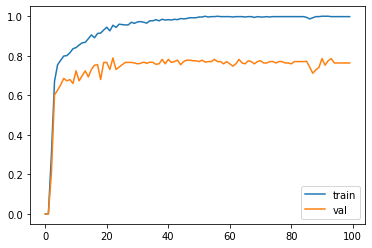

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.238806).  Saving model ...
Validation acc increased (0.238806 --> 0.593407).  Saving model ...
Validation acc increased (0.593407 --> 0.679612).  Saving model ...
Validation acc increased (0.679612 --> 0.699029).  Saving model ...
Validation acc increased (0.699029 --> 0.763636).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.763636 --> 0.800000).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.800000 --> 0.807018).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.807018 --> 0.840336).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 

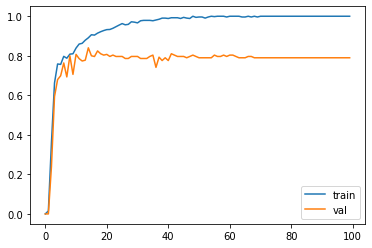

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.065574).  Saving model ...
Validation acc increased (0.065574 --> 0.623656).  Saving model ...
Validation acc increased (0.623656 --> 0.673469).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.673469 --> 0.716981).  Saving model ...
Validation acc increased (0.716981 --> 0.716981).  Saving model ...
Validation acc increased (0.716981 --> 0.722222).  Saving model ...
Validation acc increased (0.722222 --> 0.778761).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.778761 --> 0.778761).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.778761 --> 0.850000).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200


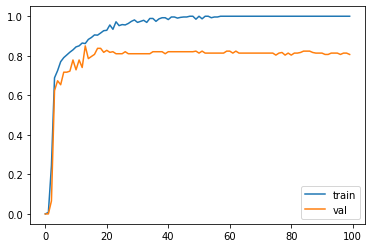

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.095238).  Saving model ...
Validation acc increased (0.095238 --> 0.539326).  Saving model ...
Validation acc increased (0.539326 --> 0.633663).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.633663 --> 0.696429).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.696429 --> 0.702703).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.702703 --> 0.703704).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.703704 --> 0.714286).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.714286 --> 0.733945).  Saving model 

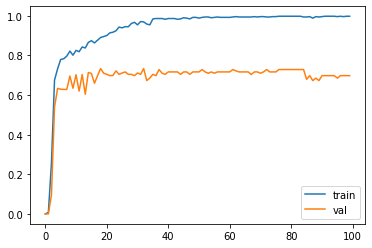

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.126984).  Saving model ...
Validation acc increased (0.126984 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.716981).  Saving model ...
Validation acc increased (0.716981 --> 0.745455).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.745455 --> 0.750000).  Saving model ...
Validation acc increased (0.750000 --> 0.750000).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.750000 --> 0.789474).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.789474 --> 0.803419).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 

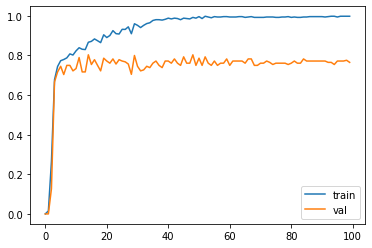

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.066667).  Saving model ...
Validation acc increased (0.066667 --> 0.522727).  Saving model ...
Validation acc increased (0.522727 --> 0.647059).  Saving model ...
Validation acc increased (0.647059 --> 0.692308).  Saving model ...
Validation acc increased (0.692308 --> 0.704762).  Saving model ...
Validation acc increased (0.704762 --> 0.733945).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.733945 --> 0.763636).  Saving model ...
Validation acc increased (0.763636 --> 0.765217).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.765217 --> 0.767857).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.767857 --> 0.782609).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Vali

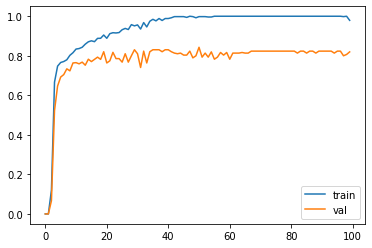

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.268657).  Saving model ...
Validation acc increased (0.268657 --> 0.577778).  Saving model ...
Validation acc increased (0.577778 --> 0.621359).  Saving model ...
Validation acc increased (0.621359 --> 0.660377).  Saving model ...
Validation acc increased (0.660377 --> 0.685185).  Saving model ...
Validation acc increased (0.685185 --> 0.685185).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.685185 --> 0.736842).  Saving model ...
Validation acc increased (0.736842 --> 0.738739).  Saving model ...
Validation acc increased (0.738739 --> 0.761062).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.761062 --> 0.789474).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.789474 --> 0.803419).  Saving model ...
EarlySto

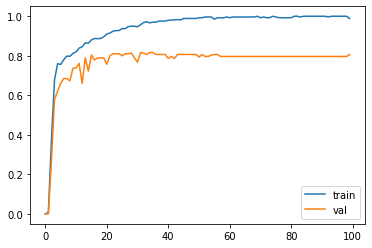

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.065574).  Saving model ...
Validation acc increased (0.065574 --> 0.481928).  Saving model ...
Validation acc increased (0.481928 --> 0.620000).  Saving model ...
Validation acc increased (0.620000 --> 0.633663).  Saving model ...
Validation acc increased (0.633663 --> 0.691589).  Saving model ...
Validation acc increased (0.691589 --> 0.691589).  Saving model ...
Validation acc increased (0.691589 --> 0.738739).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.738739 --> 0.756757).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.756757 --> 0.756757).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200


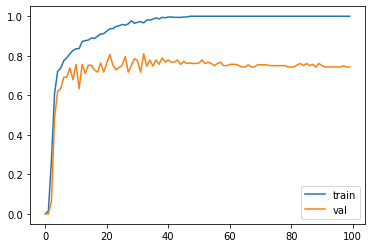

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.238806).  Saving model ...
Validation acc increased (0.238806 --> 0.615385).  Saving model ...
Validation acc increased (0.615385 --> 0.686869).  Saving model ...
Validation acc increased (0.686869 --> 0.693069).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.693069 --> 0.723810).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.723810 --> 0.737864).  Saving model ...
Validation acc increased (0.737864 --> 0.750000).  Saving model ...
Validation acc increased (0.750000 --> 0.777778).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.777778 --> 0.814159).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200


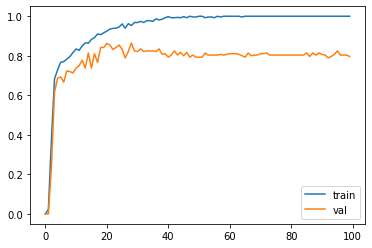

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.301370).  Saving model ...
Validation acc increased (0.301370 --> 0.602151).  Saving model ...
Validation acc increased (0.602151 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.696429).  Saving model ...
Validation acc increased (0.696429 --> 0.697248).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.697248 --> 0.714286).  Saving model ...
Validation acc increased (0.714286 --> 0.714286).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.714286 --> 0.747826).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 

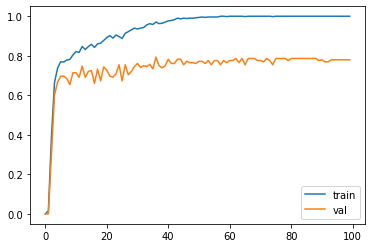

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.617021).  Saving model ...
Validation acc increased (0.617021 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.724138).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.724138 --> 0.739496).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.739496 --> 0.758621).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.758621 --> 0.758621).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.758621 --> 0.769231).  Saving model ...
EarlyStopping counter: 1 out of 

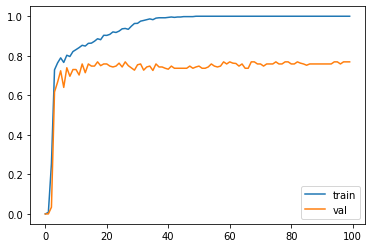

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.281690).  Saving model ...
Validation acc increased (0.281690 --> 0.653846).  Saving model ...
Validation acc increased (0.653846 --> 0.686275).  Saving model ...
Validation acc increased (0.686275 --> 0.710280).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.710280 --> 0.722222).  Saving model ...
Validation acc increased (0.722222 --> 0.740741).  Saving model ...
Validation acc increased (0.740741 --> 0.752294).  Saving model ...
Validation acc increased (0.752294 --> 0.756757).  Saving model ...
Validation acc increased (0.756757 --> 0.767857).  Saving model ...
Validation acc increased (0.767857 --> 0.778761).  Saving model ...
Validation acc increased (0.778761 --> 0.793103).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.793103 --> 0.800

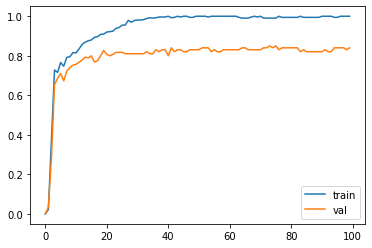

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.035088).  Saving model ...
Validation acc increased (0.035088 --> 0.184615).  Saving model ...
Validation acc increased (0.184615 --> 0.623656).  Saving model ...
Validation acc increased (0.623656 --> 0.631579).  Saving model ...
Validation acc increased (0.631579 --> 0.718447).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.718447 --> 0.735849).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.735849 --> 0.735849).  Saving model ...
Validation acc increased (0.735849 --> 0.803571).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.803571 --> 0.803571).  Saving model ...
Validation acc increased (0.803571 --> 0.814159).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.814159 -

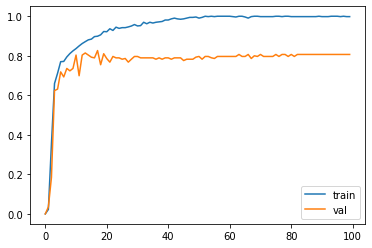

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.242424).  Saving model ...
Validation acc increased (0.242424 --> 0.680000).  Saving model ...
Validation acc increased (0.680000 --> 0.685714).  Saving model ...
Validation acc increased (0.685714 --> 0.709091).  Saving model ...
Validation acc increased (0.709091 --> 0.779661).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.779661 --> 0.779661).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out of 200
EarlyStopping counter: 9 out of 200
EarlyStopping counter: 1

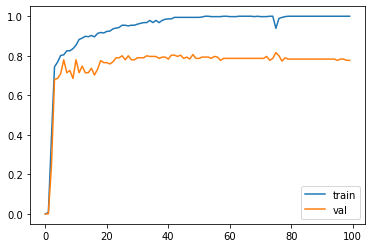

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.065574).  Saving model ...
Validation acc increased (0.065574 --> 0.630435).  Saving model ...
Validation acc increased (0.630435 --> 0.711538).  Saving model ...
Validation acc increased (0.711538 --> 0.733945).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.733945 --> 0.756757).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.756757 --> 0.800000).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.800000 --> 0.810345).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out

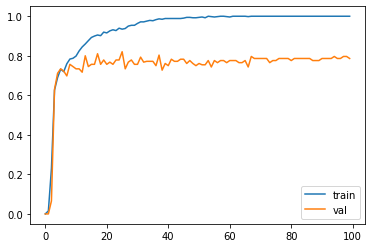

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.064516).  Saving model ...
Validation acc increased (0.064516 --> 0.574468).  Saving model ...
Validation acc increased (0.574468 --> 0.626263).  Saving model ...
Validation acc increased (0.626263 --> 0.679612).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.679612 --> 0.715596).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.715596 --> 0.761062).  Saving model ...
Validation acc increased (0.761062 --> 0.771930).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.771930 --> 0.796610).  Saving model 

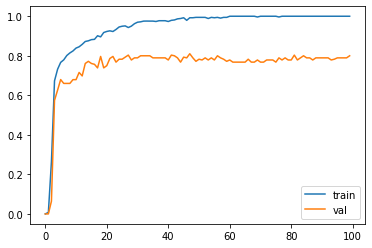

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.630435).  Saving model ...
Validation acc increased (0.630435 --> 0.660000).  Saving model ...
Validation acc increased (0.660000 --> 0.673077).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.673077 --> 0.722222).  Saving model ...
Validation acc increased (0.722222 --> 0.722222).  Saving model ...
Validation acc increased (0.722222 --> 0.756757).  Saving model ...
Validation acc increased (0.756757 --> 0.756757).  Saving model ...
Validation acc increased (0.756757 --> 0.807018).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.807018 -

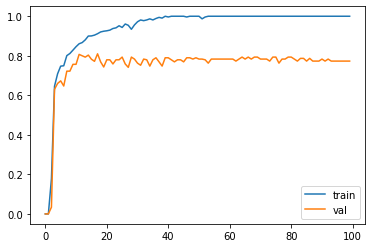

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.176471).  Saving model ...
Validation acc increased (0.176471 --> 0.586957).  Saving model ...
Validation acc increased (0.586957 --> 0.653465).  Saving model ...
Validation acc increased (0.653465 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.716981).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.716981 --> 0.728972).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.728972 --> 0.740741).  Saving model ...
Validation acc increased (0.740741 --> 0.752294).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.752294 --> 0.767857).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.767857 -

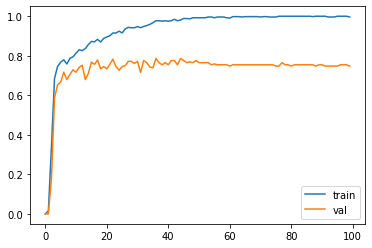

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.065574).  Saving model ...
Validation acc increased (0.065574 --> 0.425000).  Saving model ...
Validation acc increased (0.425000 --> 0.606061).  Saving model ...
Validation acc increased (0.606061 --> 0.673077).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.673077 --> 0.673077).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.673077 --> 0.679612).  Saving model ...
Validation acc increased (0.679612 --> 0.732143).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.732143 --> 0.738739).  Saving model ...
Validation acc increased (0.738739 --> 0.756757).  Saving model ...


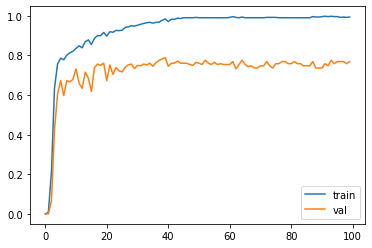

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.121212).  Saving model ...
Validation acc increased (0.121212 --> 0.549451).  Saving model ...
Validation acc increased (0.549451 --> 0.615385).  Saving model ...
Validation acc increased (0.615385 --> 0.628571).  Saving model ...
Validation acc increased (0.628571 --> 0.628571).  Saving model ...
Validation acc increased (0.628571 --> 0.678571).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.678571 --> 0.701754).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out of 200
EarlyStopping counter: 9 out

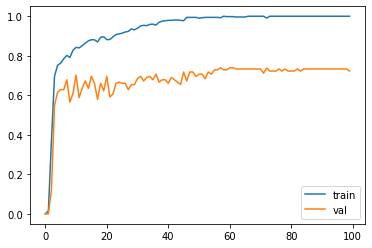

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.208955).  Saving model ...
Validation acc increased (0.208955 --> 0.610526).  Saving model ...
Validation acc increased (0.610526 --> 0.698113).  Saving model ...
Validation acc increased (0.698113 --> 0.703704).  Saving model ...
Validation acc increased (0.703704 --> 0.743363).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.743363 --> 0.761062).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.761062 --> 0.763636).  Saving model ...
Validation acc increased (0.763636 --> 0.767857).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.767857 --> 0.810811).  Saving model ...


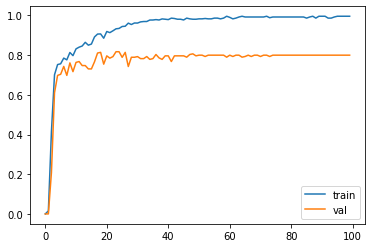

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.066667).  Saving model ...
Validation acc increased (0.066667 --> 0.534884).  Saving model ...
Validation acc increased (0.534884 --> 0.618557).  Saving model ...
Validation acc increased (0.618557 --> 0.633663).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.633663 --> 0.778761).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.778761 --> 0.782609).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.782609 --> 0.789474).  Saving model ...
Validation acc increased (0.789474 --> 0.793103).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.793103 --> 0.800000).  Saving model ...


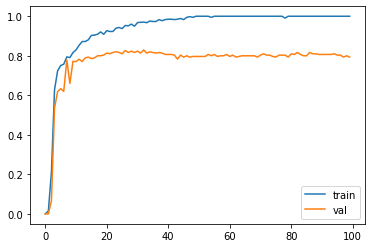

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.095238).  Saving model ...
Validation acc increased (0.095238 --> 0.574468).  Saving model ...
Validation acc increased (0.574468 --> 0.640000).  Saving model ...
Validation acc increased (0.640000 --> 0.640000).  Saving model ...
Validation acc increased (0.640000 --> 0.698113).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.698113 --> 0.703704).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.703704 --> 0.778761).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.778761 --> 0.793103).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 

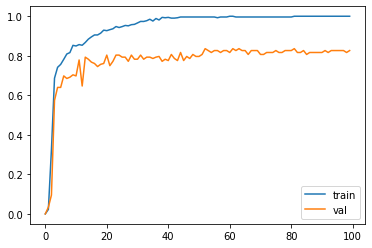

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.228571).  Saving model ...
Validation acc increased (0.228571 --> 0.632653).  Saving model ...
Validation acc increased (0.632653 --> 0.679245).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.679245 --> 0.732143).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
Validation acc increased (0.732143 --> 0.733945).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.733945 --> 0.740741).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2

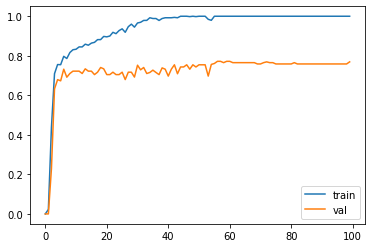

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.035088).  Saving model ...
Validation acc increased (0.035088 --> 0.281690).  Saving model ...
Validation acc increased (0.281690 --> 0.623656).  Saving model ...
Validation acc increased (0.623656 --> 0.691589).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.691589 --> 0.703704).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.703704 --> 0.754386).  Saving model ...
Validation acc increased (0.754386 --> 0.771930).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
Validation acc increased (0.771930 --> 0.778761).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out

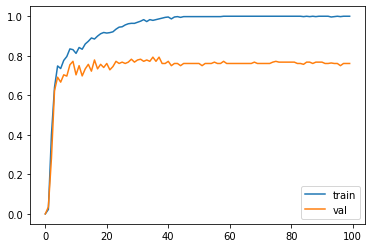

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.034483).  Saving model ...
Validation acc increased (0.034483 --> 0.536585).  Saving model ...
Validation acc increased (0.536585 --> 0.701031).  Saving model ...
Validation acc increased (0.701031 --> 0.718447).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.718447 --> 0.742857).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.742857 --> 0.788991).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.788991 --> 0.788991).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.788991 --> 0.792793).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 

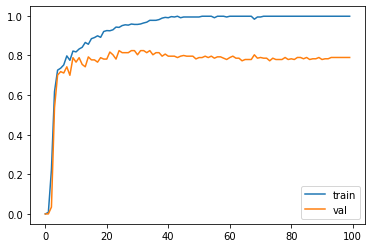

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.065574).  Saving model ...
Validation acc increased (0.065574 --> 0.545455).  Saving model ...
Validation acc increased (0.545455 --> 0.591837).  Saving model ...
Validation acc increased (0.591837 --> 0.632653).  Saving model ...
Validation acc increased (0.632653 --> 0.704762).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.704762 --> 0.716981).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.716981 --> 0.716981).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.716981 --> 0.723810).  Saving model ...
Validation acc increased (0.723810 --> 0.789474).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200


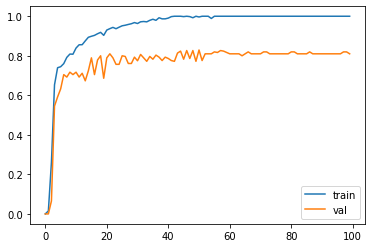

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.067797).  Saving model ...
Validation acc increased (0.067797 --> 0.600000).  Saving model ...
Validation acc increased (0.600000 --> 0.653846).  Saving model ...
Validation acc increased (0.653846 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.673077).  Saving model ...
Validation acc increased (0.673077 --> 0.698113).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.698113 --> 0.775862).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.775862 --> 0.775862).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.775862 --> 0.779661).  Saving model ...


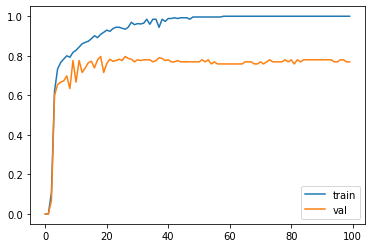

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.125000).  Saving model ...
Validation acc increased (0.125000 --> 0.494118).  Saving model ...
Validation acc increased (0.494118 --> 0.568421).  Saving model ...
Validation acc increased (0.568421 --> 0.640777).  Saving model ...
Validation acc increased (0.640777 --> 0.697248).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.697248 --> 0.727273).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.727273 --> 0.727273).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out

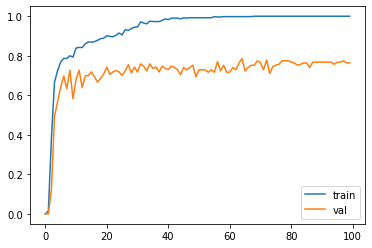

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.065574).  Saving model ...
Validation acc increased (0.065574 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.679612).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.679612 --> 0.691589).  Saving model ...
Validation acc increased (0.691589 --> 0.738739).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.738739 --> 0.775862).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.775862 --> 0.775862).  Saving model ...
EarlyStopping counter: 1 out

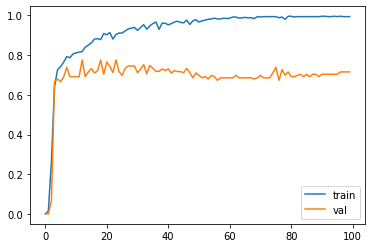

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.065574).  Saving model ...
Validation acc increased (0.065574 --> 0.534884).  Saving model ...
Validation acc increased (0.534884 --> 0.604167).  Saving model ...
Validation acc increased (0.604167 --> 0.612245).  Saving model ...
Validation acc increased (0.612245 --> 0.640777).  Saving model ...
Validation acc increased (0.640777 --> 0.653846).  Saving model ...
Validation acc increased (0.653846 --> 0.732143).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.732143 --> 0.754386).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.754386 --> 0.756757).  Saving model ...
Validation acc increased (0.756757 --> 0.786325).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.786325 --> 0.789916).  Saving model ...
EarlySto

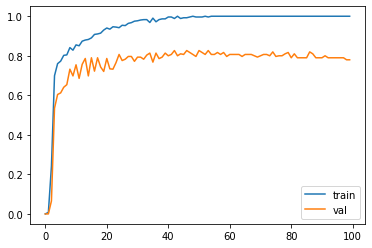

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.095238).  Saving model ...
Validation acc increased (0.095238 --> 0.623656).  Saving model ...
Validation acc increased (0.623656 --> 0.686869).  Saving model ...
Validation acc increased (0.686869 --> 0.699029).  Saving model ...
Validation acc increased (0.699029 --> 0.699029).  Saving model ...
Validation acc increased (0.699029 --> 0.745455).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out of 200
EarlyStopping counter: 9 out of 200
EarlyStopping counter: 10 out of 200
EarlyStopping counter: 11 out of 200
EarlyStopping counter: 12 out of 200
Validation acc increa

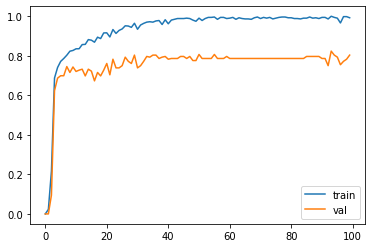

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.064516).  Saving model ...
Validation acc increased (0.064516 --> 0.584270).  Saving model ...
Validation acc increased (0.584270 --> 0.631579).  Saving model ...
Validation acc increased (0.631579 --> 0.660000).  Saving model ...
Validation acc increased (0.660000 --> 0.710280).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.710280 --> 0.738739).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
Validation acc increased (0.738739 --> 0.750000).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out

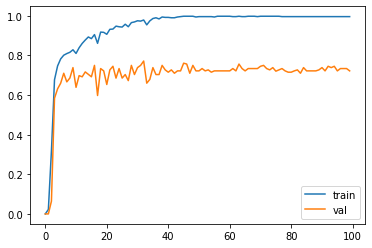

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.066667).  Saving model ...
Validation acc increased (0.066667 --> 0.351351).  Saving model ...
Validation acc increased (0.351351 --> 0.618557).  Saving model ...
Validation acc increased (0.618557 --> 0.653846).  Saving model ...
Validation acc increased (0.653846 --> 0.673267).  Saving model ...
Validation acc increased (0.673267 --> 0.752294).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.752294 --> 0.763636).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.763636 --> 0.807018).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 

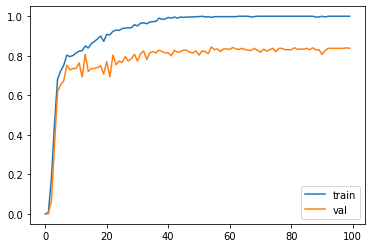

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.328767).  Saving model ...
Validation acc increased (0.328767 --> 0.604167).  Saving model ...
Validation acc increased (0.604167 --> 0.640000).  Saving model ...
Validation acc increased (0.640000 --> 0.666667).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.666667 --> 0.685714).  Saving model ...
Validation acc increased (0.685714 --> 0.698113).  Saving model ...
Validation acc increased (0.698113 --> 0.698113).  Saving model ...
Validation acc increased (0.698113 --> 0.722222).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.722222 --> 0.733945).  Saving model ...
Validation acc increased (0.733945 --> 0.820513).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Earl

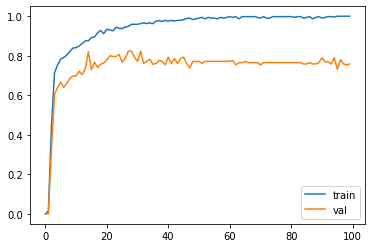

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.187500).  Saving model ...
Validation acc increased (0.187500 --> 0.597701).  Saving model ...
Validation acc increased (0.597701 --> 0.707071).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.707071 --> 0.707071).  Saving model ...
Validation acc increased (0.707071 --> 0.707071).  Saving model ...
Validation acc increased (0.707071 --> 0.737864).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.737864 --> 0.737864).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.737864 --> 0.737864).  Saving model ...
Validation acc increased (0.737864 --> 0.807339).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.807339 --> 0.807339).  Saving model ...
Earl

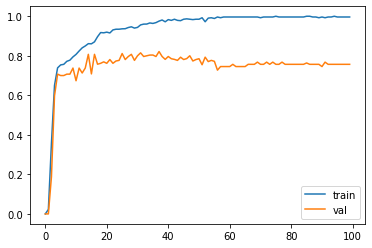

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.500000).  Saving model ...
Validation acc increased (0.500000 --> 0.647059).  Saving model ...
Validation acc increased (0.647059 --> 0.660194).  Saving model ...
Validation acc increased (0.660194 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.679245).  Saving model ...
Validation acc increased (0.679245 --> 0.709091).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.709091 --> 0.732143).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
Validation acc increased (0.732143 --> 0.736842).  Saving model ...


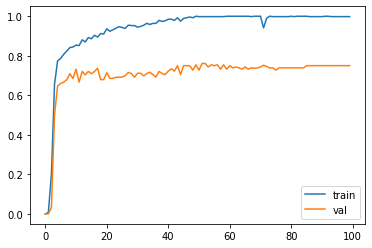

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.034483).  Saving model ...
Validation acc increased (0.034483 --> 0.315789).  Saving model ...
Validation acc increased (0.315789 --> 0.574468).  Saving model ...
Validation acc increased (0.574468 --> 0.633663).  Saving model ...
Validation acc increased (0.633663 --> 0.685714).  Saving model ...
Validation acc increased (0.685714 --> 0.698113).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.698113 --> 0.711538).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.711538 --> 0.723810).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.

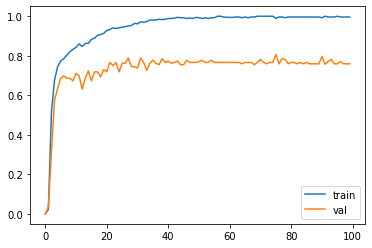

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.129032).  Saving model ...
Validation acc increased (0.129032 --> 0.551724).  Saving model ...
Validation acc increased (0.551724 --> 0.626263).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.626263 --> 0.634615).  Saving model ...
Validation acc increased (0.634615 --> 0.660377).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.660377 --> 0.690909).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.690909 --> 0.747826).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.747826 --> 0.769231).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 

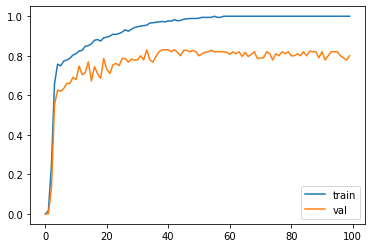

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.176471).  Saving model ...
Validation acc increased (0.176471 --> 0.545455).  Saving model ...
Validation acc increased (0.545455 --> 0.639175).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.639175 --> 0.698113).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.698113 --> 0.745455).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
Validation acc increased (0.745455 --> 0.754386).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased

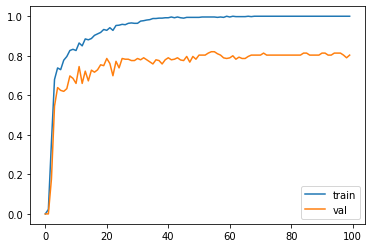

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.574713).  Saving model ...
Validation acc increased (0.574713 --> 0.691589).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.691589 --> 0.722222).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.722222 --> 0.756757).  Saving model ...
Validation acc increased (0.756757 --> 0.756757).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.756757 --> 0.767857).  Saving model ...
Validation acc increased (0.767857 --> 0.767857).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.7678

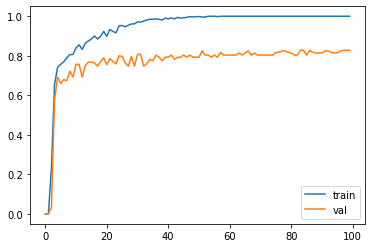

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.373333).  Saving model ...
Validation acc increased (0.373333 --> 0.606061).  Saving model ...
Validation acc increased (0.606061 --> 0.654206).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.654206 --> 0.697248).  Saving model ...
Validation acc increased (0.697248 --> 0.720721).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out of 200
EarlyStopping counter: 9 out of 200
EarlyStopping counter: 10 out of 200
EarlyStopping counter: 11 out of 200
Validation acc increas

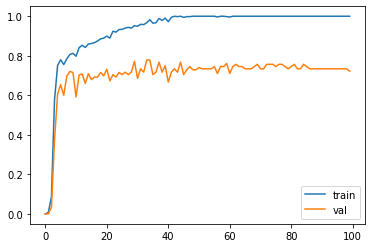

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.176471).  Saving model ...
Validation acc increased (0.176471 --> 0.595745).  Saving model ...
Validation acc increased (0.595745 --> 0.620000).  Saving model ...
Validation acc increased (0.620000 --> 0.640000).  Saving model ...
Validation acc increased (0.640000 --> 0.685714).  Saving model ...
Validation acc increased (0.685714 --> 0.685714).  Saving model ...
Validation acc increased (0.685714 --> 0.715596).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.715596 --> 0.756757).  Saving model ...
Validation acc increased (0.756757 --> 0.756757).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.756757 --> 0.756757).  Saving model ...
Validation acc increased (0.756757 --> 0.756757).  Saving model ...
EarlySto

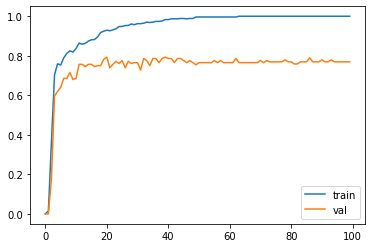

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.179104).  Saving model ...
Validation acc increased (0.179104 --> 0.522727).  Saving model ...
Validation acc increased (0.522727 --> 0.606061).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.606061 --> 0.628571).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.628571 --> 0.660377).  Saving model ...
Validation acc increased (0.660377 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.698113).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.698113 --> 0.703704).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.703704 --> 0.727273).  Saving model ...


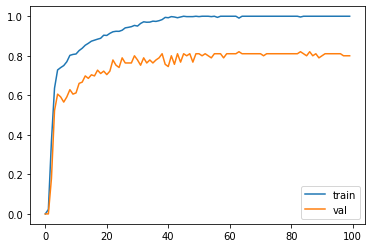

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.067797).  Saving model ...
Validation acc increased (0.067797 --> 0.590909).  Saving model ...
Validation acc increased (0.590909 --> 0.638298).  Saving model ...
Validation acc increased (0.638298 --> 0.659794).  Saving model ...
Validation acc increased (0.659794 --> 0.693069).  Saving model ...
Validation acc increased (0.693069 --> 0.723810).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.723810 --> 0.759259).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.759259 --> 0.781818).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.781818 --> 0.789474).  Saving model ...
EarlyStopping counter: 1 out of 200


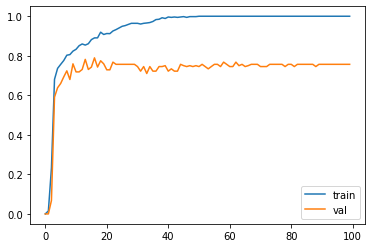

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.098361).  Saving model ...
Validation acc increased (0.098361 --> 0.559140).  Saving model ...
Validation acc increased (0.559140 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.690265).  Saving model ...
Validation acc increased (0.690265 --> 0.690265).  Saving model ...
Validation acc increased (0.690265 --> 0.713043).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.713043 --> 0.750000).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.750000 --> 0.773109).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.773109 --> 0.774775).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.774775 --> 0.789474).  Saving model ...
Validation acc increased (0.789474 --> 0

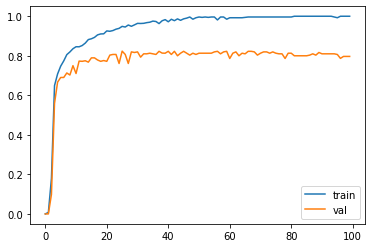

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.034483).  Saving model ...
Validation acc increased (0.034483 --> 0.277778).  Saving model ...
Validation acc increased (0.277778 --> 0.534884).  Saving model ...
Validation acc increased (0.534884 --> 0.632653).  Saving model ...
Validation acc increased (0.632653 --> 0.646465).  Saving model ...
Validation acc increased (0.646465 --> 0.646465).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.646465 --> 0.752294).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.752294 --> 0.756757).  Saving model ...
Validation acc increased (0.756757 --> 0.778761).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.778761 --> 0.778761).  Saving model ...
EarlyStopping counter: 1 out of 200


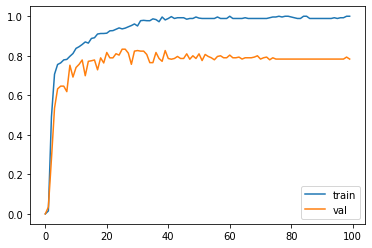

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.095238).  Saving model ...
Validation acc increased (0.095238 --> 0.555556).  Saving model ...
Validation acc increased (0.555556 --> 0.646465).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.646465 --> 0.647059).  Saving model ...
Validation acc increased (0.647059 --> 0.673077).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.673077 --> 0.738739).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.738739 --> 0.761062).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.761062 --> 0.789916).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 

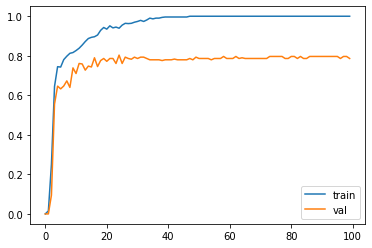

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.488372).  Saving model ...
Validation acc increased (0.488372 --> 0.537634).  Saving model ...
Validation acc increased (0.537634 --> 0.666667).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.666667 --> 0.703704).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.703704 --> 0.711538).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.711538 --> 0.711538).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out

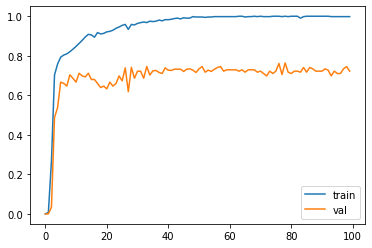

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.096774).  Saving model ...
Validation acc increased (0.096774 --> 0.551724).  Saving model ...
Validation acc increased (0.551724 --> 0.589474).  Saving model ...
Validation acc increased (0.589474 --> 0.620000).  Saving model ...
Validation acc increased (0.620000 --> 0.620000).  Saving model ...
Validation acc increased (0.620000 --> 0.782609).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
Validation acc increased (0.782609 --> 0.796610).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out

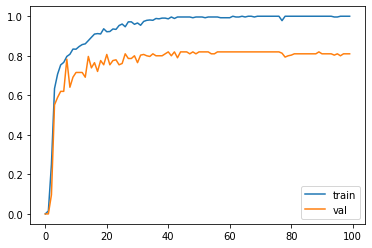

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.151515).  Saving model ...
Validation acc increased (0.151515 --> 0.645833).  Saving model ...
Validation acc increased (0.645833 --> 0.673267).  Saving model ...
Validation acc increased (0.673267 --> 0.686275).  Saving model ...
Validation acc increased (0.686275 --> 0.747664).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.747664 --> 0.774775).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.774775 --> 0.785714).  Saving model ...
Validation acc increased (0.785714 --> 0.785714).  Saving model ...
Validation acc increased (0.785714 --> 0.785714).  Saving model ...
Validation acc increased (0.785714 --> 0.810345).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Earl

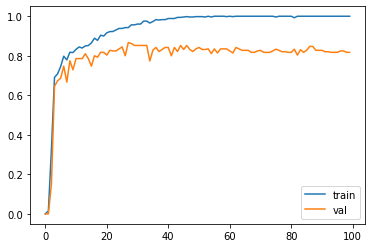

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.129032).  Saving model ...
Validation acc increased (0.129032 --> 0.608696).  Saving model ...
Validation acc increased (0.608696 --> 0.640000).  Saving model ...
Validation acc increased (0.640000 --> 0.691589).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.691589 --> 0.698113).  Saving model ...
Validation acc increased (0.698113 --> 0.733945).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.733945 --> 0.775862).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.775862 --> 0.775862).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.775862 --> 0.775862).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.775862 -

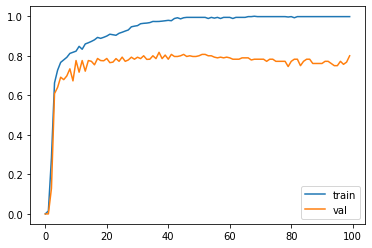

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033333).  Saving model ...
Validation acc increased (0.033333 --> 0.593407).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.593407 --> 0.627451).  Saving model ...
Validation acc increased (0.627451 --> 0.633663).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.633663 --> 0.647059).  Saving model ...
Validation acc increased (0.647059 --> 0.709091).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out of 200
Validation acc increased (0.709091 --> 0.711538).  Saving model ...
EarlyStopping counter: 1 out

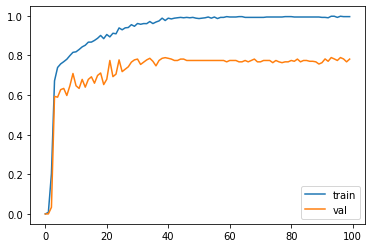

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.066667).  Saving model ...
Validation acc increased (0.066667 --> 0.574713).  Saving model ...
Validation acc increased (0.574713 --> 0.625000).  Saving model ...
Validation acc increased (0.625000 --> 0.645833).  Saving model ...
Validation acc increased (0.645833 --> 0.680000).  Saving model ...
Validation acc increased (0.680000 --> 0.686275).  Saving model ...
Validation acc increased (0.686275 --> 0.686275).  Saving model ...
Validation acc increased (0.686275 --> 0.711538).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.711538 --> 0.723810).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.723810 --> 0.792793).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Earl

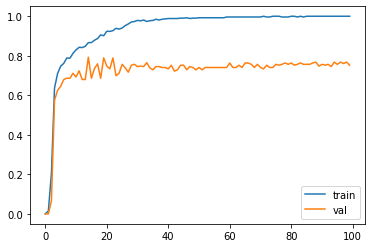

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.184615).  Saving model ...
Validation acc increased (0.184615 --> 0.652632).  Saving model ...
Validation acc increased (0.652632 --> 0.711538).  Saving model ...
Validation acc increased (0.711538 --> 0.711538).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.711538 --> 0.747664).  Saving model ...
Validation acc increased (0.747664 --> 0.747664).  Saving model ...
Validation acc increased (0.747664 --> 0.747664).  Saving model ...
Validation acc increased (0.747664 --> 0.766355).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.766355 --> 0.770642).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.770642 --> 0.792793).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.792793 --> 0

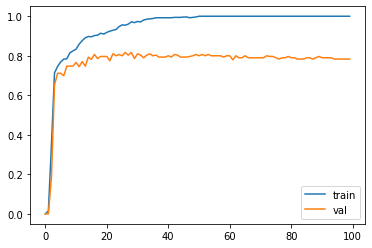

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.147059).  Saving model ...
Validation acc increased (0.147059 --> 0.580645).  Saving model ...
Validation acc increased (0.580645 --> 0.686275).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.686275 --> 0.752294).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.752294 --> 0.759259).  Saving model ...
Validation acc increased (0.759259 --> 0.778761).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.778761 --> 0.793103).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.793103 --> 0.800000).  Saving model 

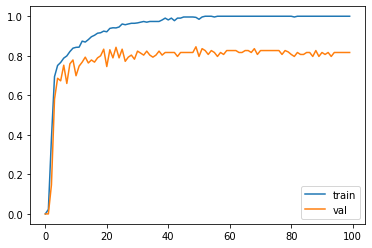

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.093750).  Saving model ...
Validation acc increased (0.093750 --> 0.625000).  Saving model ...
Validation acc increased (0.625000 --> 0.679612).  Saving model ...
Validation acc increased (0.679612 --> 0.698113).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.698113 --> 0.703704).  Saving model ...
Validation acc increased (0.703704 --> 0.705882).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.705882 --> 0.728972).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.728972 --> 0.758621).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 

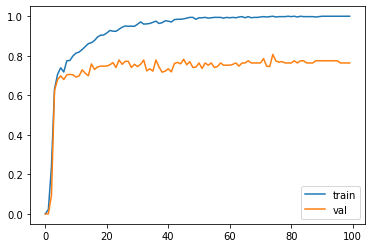

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.264706).  Saving model ...
Validation acc increased (0.264706 --> 0.645161).  Saving model ...
Validation acc increased (0.645161 --> 0.672897).  Saving model ...
Validation acc increased (0.672897 --> 0.678899).  Saving model ...
Validation acc increased (0.678899 --> 0.720721).  Saving model ...
Validation acc increased (0.720721 --> 0.723810).  Saving model ...
Validation acc increased (0.723810 --> 0.747826).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.747826 --> 0.775862).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.775862 --> 0.807018).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200


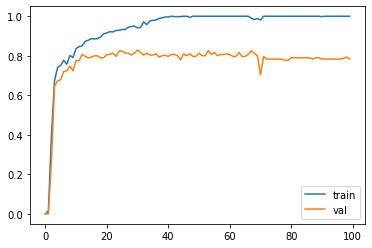

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.264706).  Saving model ...
Validation acc increased (0.264706 --> 0.586957).  Saving model ...
Validation acc increased (0.586957 --> 0.653465).  Saving model ...
Validation acc increased (0.653465 --> 0.673077).  Saving model ...
Validation acc increased (0.673077 --> 0.685714).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.685714 --> 0.692308).  Saving model ...
Validation acc increased (0.692308 --> 0.699029).  Saving model ...
Validation acc increased (0.699029 --> 0.704762).  Saving model ...
Validation acc increased (0.704762 --> 0.711538).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.711538 --> 0.728972).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.728972 --> 0.778761).  Saving model ...
EarlySto

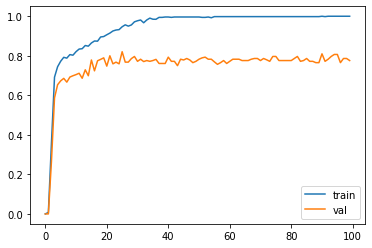

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.031746).  Saving model ...
Validation acc increased (0.031746 --> 0.593407).  Saving model ...
Validation acc increased (0.593407 --> 0.653465).  Saving model ...
Validation acc increased (0.653465 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.740741).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.740741 --> 0.740741).  Saving model ...
Validation acc increased (0.740741 --> 0.800000).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.800000 --> 0.817391).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 

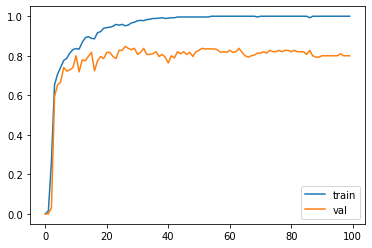

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.100000).  Saving model ...
Validation acc increased (0.100000 --> 0.389610).  Saving model ...
Validation acc increased (0.389610 --> 0.602151).  Saving model ...
Validation acc increased (0.602151 --> 0.631579).  Saving model ...
Validation acc increased (0.631579 --> 0.653465).  Saving model ...
Validation acc increased (0.653465 --> 0.679612).  Saving model ...
Validation acc increased (0.679612 --> 0.740741).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.740741 --> 0.778761).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.778761 --> 0.800000).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200


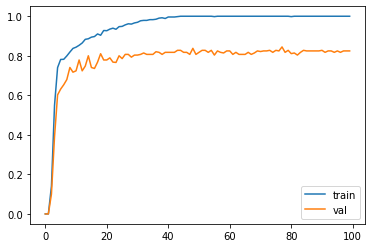

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.034483).  Saving model ...
Validation acc increased (0.034483 --> 0.228571).  Saving model ...
Validation acc increased (0.228571 --> 0.625000).  Saving model ...
Validation acc increased (0.625000 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.709091).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.709091 --> 0.732143).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out of 200
EarlyStopping counter: 9 out of 200
EarlyStopping counter: 10 out of 200
EarlyStopping counter: 11 out of 200
EarlyStopping counter: 12 out of 200
EarlyStopping cou

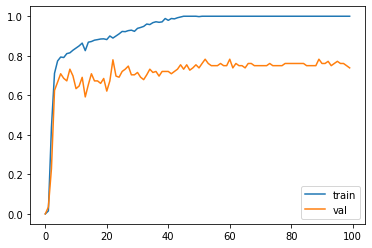

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.541176).  Saving model ...
Validation acc increased (0.541176 --> 0.659794).  Saving model ...
Validation acc increased (0.659794 --> 0.673469).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.673469 --> 0.718447).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.718447 --> 0.730769).  Saving model ...
Validation acc increased (0.730769 --> 0.754717).  Saving model ...
Validation acc increased (0.754717 --> 0.754717).  Saving model ...
Validation acc increased (0.754717 --> 0.810811).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.810811 --> 0.824561).  Saving model ...
EarlyStopping counter: 1 out of 200
Earl

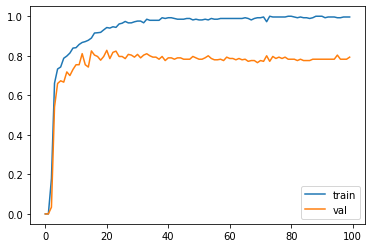

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.187500).  Saving model ...
Validation acc increased (0.187500 --> 0.652632).  Saving model ...
Validation acc increased (0.652632 --> 0.686869).  Saving model ...
Validation acc increased (0.686869 --> 0.732673).  Saving model ...
Validation acc increased (0.732673 --> 0.766355).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.766355 --> 0.770642).  Saving model ...
Validation acc increased (0.770642 --> 0.770642).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.770642 --> 0.770642).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.770642 --> 0.780952).  Saving model ...


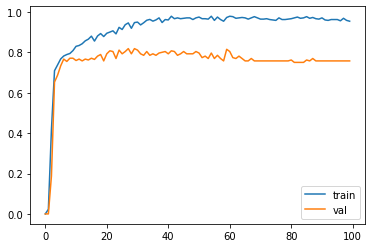

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.190476).  Saving model ...
Validation acc increased (0.190476 --> 0.613636).  Saving model ...
Validation acc increased (0.613636 --> 0.742857).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.742857 --> 0.792793).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.792793 --> 0.807339).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.807339 --> 0.839286).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3

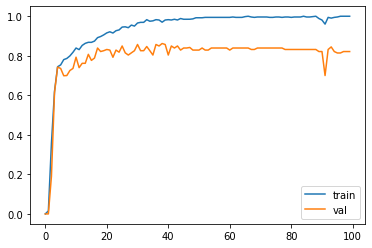

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.125000).  Saving model ...
Validation acc increased (0.125000 --> 0.568182).  Saving model ...
Validation acc increased (0.568182 --> 0.673267).  Saving model ...
Validation acc increased (0.673267 --> 0.705882).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.705882 --> 0.723810).  Saving model ...
Validation acc increased (0.723810 --> 0.723810).  Saving model ...
Validation acc increased (0.723810 --> 0.770642).  Saving model ...
Validation acc increased (0.770642 --> 0.781818).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.781818 --> 0.824561).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200


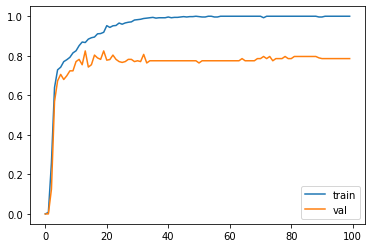

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.065574).  Saving model ...
Validation acc increased (0.065574 --> 0.617021).  Saving model ...
Validation acc increased (0.617021 --> 0.692308).  Saving model ...
Validation acc increased (0.692308 --> 0.699029).  Saving model ...
Validation acc increased (0.699029 --> 0.722222).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.722222 --> 0.723810).  Saving model ...
Validation acc increased (0.723810 --> 0.728972).  Saving model ...
Validation acc increased (0.728972 --> 0.774775).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.774775 --> 0.792793).  Saving model ...
Validation acc increased (0.792793 --> 0.834783).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Earl

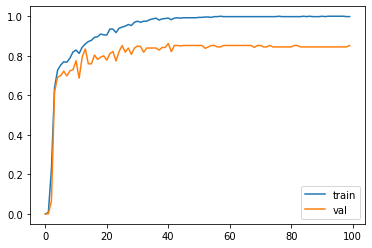

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.067797).  Saving model ...
Validation acc increased (0.067797 --> 0.720000).  Saving model ...
Validation acc increased (0.720000 --> 0.750000).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.750000 --> 0.776860).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.776860 --> 0.776860).  Saving model ...
Validation acc increased (0.776860 --> 0.783333).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.783333 --> 0.786325).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.786325 --> 0.786325).  Saving model 

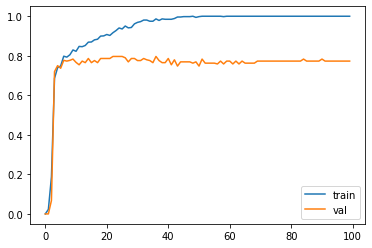

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.067797).  Saving model ...
Validation acc increased (0.067797 --> 0.571429).  Saving model ...
Validation acc increased (0.571429 --> 0.647619).  Saving model ...
Validation acc increased (0.647619 --> 0.672897).  Saving model ...
Validation acc increased (0.672897 --> 0.720721).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.720721 --> 0.720721).  Saving model ...
Validation acc increased (0.720721 --> 0.743363).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.743363 --> 0.758621).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 

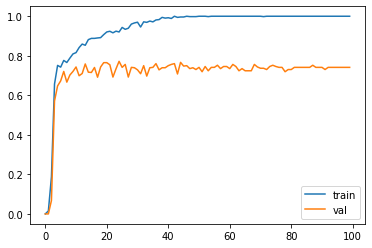

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033333).  Saving model ...
Validation acc increased (0.033333 --> 0.568182).  Saving model ...
Validation acc increased (0.568182 --> 0.612245).  Saving model ...
Validation acc increased (0.612245 --> 0.612245).  Saving model ...
Validation acc increased (0.612245 --> 0.640777).  Saving model ...
Validation acc increased (0.640777 --> 0.727273).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.727273 --> 0.756757).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.756757 --> 0.820513).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 

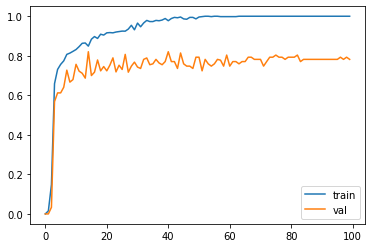

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033898).  Saving model ...
Validation acc increased (0.033898 --> 0.301370).  Saving model ...
Validation acc increased (0.301370 --> 0.593407).  Saving model ...
Validation acc increased (0.593407 --> 0.597938).  Saving model ...
Validation acc increased (0.597938 --> 0.613861).  Saving model ...
Validation acc increased (0.613861 --> 0.634615).  Saving model ...
Validation acc increased (0.634615 --> 0.647619).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.647619 --> 0.697248).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
Validation acc increased (0.6972

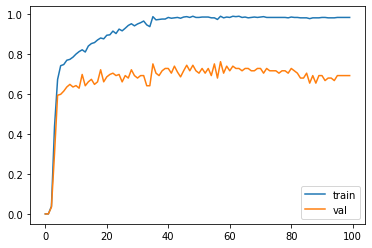

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.153846).  Saving model ...
Validation acc increased (0.153846 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.673267).  Saving model ...
Validation acc increased (0.673267 --> 0.679245).  Saving model ...
Validation acc increased (0.679245 --> 0.715596).  Saving model ...
Validation acc increased (0.715596 --> 0.722222).  Saving model ...
Validation acc increased (0.722222 --> 0.738739).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
Validation acc increased (0.738739 --> 0.803419).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 

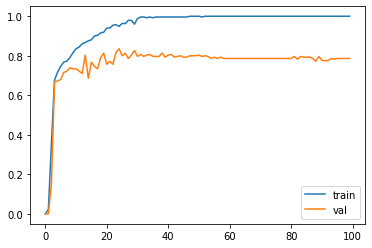

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.090909).  Saving model ...
Validation acc increased (0.090909 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.666667).  Saving model ...
Validation acc increased (0.666667 --> 0.730435).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.730435 --> 0.752137).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.752137 --> 0.773109).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out of 200
EarlyStopping counter: 9 out of 200
EarlyStopping counter: 10 out of 200
EarlyStopping counter: 

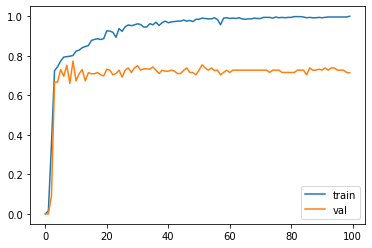

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.301370).  Saving model ...
Validation acc increased (0.301370 --> 0.559140).  Saving model ...
Validation acc increased (0.559140 --> 0.627451).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.627451 --> 0.628571).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.628571 --> 0.714286).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.714286 --> 0.743363).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.743363 --> 0.754386).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out

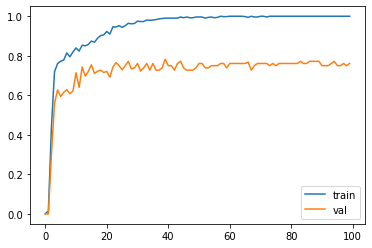

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.034483).  Saving model ...
Validation acc increased (0.034483 --> 0.264706).  Saving model ...
Validation acc increased (0.264706 --> 0.660000).  Saving model ...
Validation acc increased (0.660000 --> 0.673077).  Saving model ...
Validation acc increased (0.673077 --> 0.679245).  Saving model ...
Validation acc increased (0.679245 --> 0.703704).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.703704 --> 0.704762).  Saving model ...
Validation acc increased (0.704762 --> 0.750000).  Saving model ...
Validation acc increased (0.750000 --> 0.752294).  Saving model ...
Validation acc increased (0.752294 --> 0.752294).  Saving model ...
Validation acc increased (0.752294 --> 0.766355).  Saving model ...
Validation acc increased (0.766355 --> 0.785714).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validati

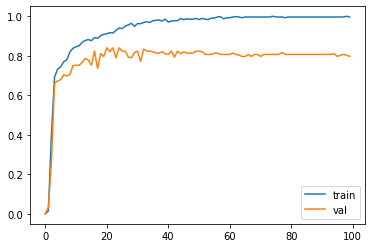

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.034483).  Saving model ...
Validation acc increased (0.034483 --> 0.320000).  Saving model ...
Validation acc increased (0.320000 --> 0.673077).  Saving model ...
Validation acc increased (0.673077 --> 0.673267).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
Validation acc increased (0.673267 --> 0.679612).  Saving model ...
Validation acc increased (0.679612 --> 0.716981).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.716981 --> 0.796460).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.796460 --> 0.796460).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out

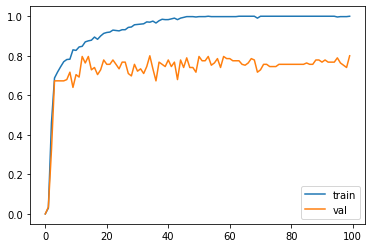

Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.000000).  Saving model ...
Validation acc increased (0.000000 --> 0.033333).  Saving model ...
Validation acc increased (0.033333 --> 0.500000).  Saving model ...
Validation acc increased (0.500000 --> 0.620000).  Saving model ...
Validation acc increased (0.620000 --> 0.640777).  Saving model ...
EarlyStopping counter: 1 out of 200
Validation acc increased (0.640777 --> 0.666667).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
Validation acc increased (0.666667 --> 0.796610).  Saving model ...
EarlyStopping counter: 1 out of 200
EarlyStopping counter: 2 out of 200
EarlyStopping counter: 3 out of 200
EarlyStopping counter: 4 out of 200
EarlyStopping counter: 5 out of 200
EarlyStopping counter: 6 out of 200
EarlyStopping counter: 7 out of 200
EarlyStopping counter: 8 out of 200
EarlyStopping counter: 9

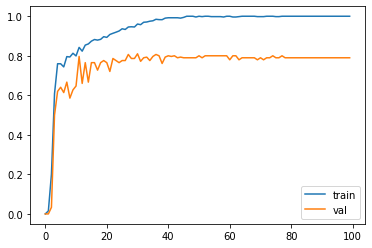

In [14]:
num_hidden_channels = 2
hidden_channels_dims = [32,16]
activation = 'ReLU'
Patience = 200
Dropout = 0.5 
Learning_rate = 0.001


AD_graph={}
CN_graph={}
for sub_id in (AD_dict):
    AD_graph[sub_id] = create_graph(timeseries=AD_dict[sub_id], y=0)
for sub_id in (CN_dict):
    CN_graph[sub_id] = create_graph(timeseries=CN_dict[sub_id], y=1)

final_train_accs = []
final_test_accs = []
final_val_accs = []
all_train_accs = []
all_val_accs = []
all_test_accs = []
final_train_f1s = []
final_val_f1s = []
final_test_f1s = []

seeds=100
for i in range(1,seeds+1):
    # print(i)
    random.seed(i)
    np.random.seed(i)

    AD_train_data = [AD_graph[sub_id] for sub_id in AD_train[i-1]]
    CN_train_data = [CN_graph[sub_id] for sub_id in CN_train[i-1]]
    residual = len(CN_train_data) - 2*len(AD_train_data)
    extra = random.sample(AD_train_data, residual)
    AD_train_data = AD_train_data*2 + extra

    train_data = AD_train_data + CN_train_data
    train_label = [0]*len(AD_train_data) + [1]*len(CN_train_data)
    train_data,train_label = shuffle(train_data, train_label, random_state=i)

    val_data = [AD_graph[sub_id] for sub_id in AD_val[i-1]] + [CN_graph[sub_id] for sub_id in CN_val[i-1]]
    val_label = [0]*len(AD_val[i-1]) + [1]*len(CN_val[i-1])
    val_data, val_label = shuffle(val_data, val_label, random_state=i)

    test_data = [AD_graph[sub_id] for sub_id in AD_test[i-1]] + [CN_graph[sub_id] for sub_id in CN_test[i-1]]
    test_label = [0]*len(AD_test[i-1]) + [1]*len(CN_test[i-1])
    test_data,test_label = shuffle(test_data, test_label, random_state=i)

    train_accs = []
    val_accs = []
    test_accs = []

    train_f1s = []
    val_f1s = []
    test_f1s = []

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

    model = GAT(dim1=116, num_hidden_channels=num_hidden_channels, hidden_channels_dims=hidden_channels_dims)
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    epochs=100

    os.makedirs(f"GAT_head1/{activation}/hidden:{hidden_channels_dims}", exist_ok=True)
    checkpt_path = f"GAT_head1/{activation}/hidden:{hidden_channels_dims}/checkpoint_seed_{i}.pt"
    early_stopping = EarlyStopping(patience=Patience, verbose=True, path=checkpt_path)

    for epoch in range(1,epochs+1):
        train(model)
        train_f1 = f1(train_loader)
        val_f1 = f1(val_loader)
        train_f1s.append(train_f1)
        val_f1s.append(val_f1)
        early_stopping(val_f1, model)
        if early_stopping.early_stop:
            print(f"Early stopping at epoch:{epoch}")
#                 final_val_accs.append(early_stopping.val_acc_max)
            print(f'GCN graph classification Epoch: {epoch:03d}, Train f1: {train_f1:.4f}, Val f1: {early_stopping.val_acc_max:.4f}')
            break
        if epoch==epochs:
            print(f'GCN graph classification Epoch: {epoch:03d}, Train f1: {train_f1:.4f}, Val f1: {early_stopping.val_acc_max:.4f}')
#                 final_val_accs.append(early_stopping.val_acc_max)

    plt.plot(train_f1s,label='train')
    plt.plot(val_f1s,label='val')
    plt.legend()
    plt.show()


#         print('seed no.:',i)
#         print("GCN Final accuracy average = ", sum(final_val_accs)/len(final_val_accs))
#         print('\n\n')

    model = GAT(dim1=116, num_hidden_channels=num_hidden_channels, hidden_channels_dims=hidden_channels_dims)
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
        model.to(device)
    checkpt_path = f"GAT_head1/{activation}/hidden:{hidden_channels_dims}"
    model.load_state_dict(torch.load(checkpt_path+f"/checkpoint_seed_{i}.pt"))
    final_train_accs.append(test(train_loader))
    final_test_accs.append(test(test_loader))
    final_val_accs.append(test(val_loader))

    final_train_f1s.append(f1(train_loader))
    final_test_f1s.append(f1(test_loader))
    final_val_f1s.append(f1(val_loader))

with open(f"GAT_head1/{activation}/hidden:{hidden_channels_dims}/report", "w") as file:
    file.write(f"num_hidden_channels={num_hidden_channels}\n"
               f"hidden_channels_dims={hidden_channels_dims}\n"
               f"Activation={activation}\n"
               f"Patience={Patience}\n"
               f"Dropout={Dropout}\n"
               f"Learning_rate={Learning_rate}\n"
               f"seeds={seeds}\n"
               f"epochs={epochs}\n"
               f"train_avg_accuracy={stat.mean(final_train_accs)*100:0.2f}%\n"
               f"train_accuracy_stdev={stat.stdev(final_train_accs)*100:0.2f}%\n"
               f"train_avg_f1={stat.mean(final_train_f1s):0.2f}\n"
               f"train_f1_stdev={stat.stdev(final_train_f1s):0.2f}\n"
               f"val_avg_accuracy={stat.mean(final_val_accs)*100:0.2f}%\n"
               f"val_accuracy_stdev={stat.stdev(final_val_accs)*100:0.2f}%\n"
               f"val_avg_f1={stat.mean(final_val_f1s):0.2f}\n"
               f"val_f1_stdev={stat.stdev(final_val_f1s):0.2f}\n"
               f"test_avg_accuracy={stat.mean(final_test_accs)*100:0.2f}%\n"
               f"test_accuracy_stdev={stat.stdev(final_test_accs)*100:0.2f}%\n"
               f"test_avg_f1={stat.mean(final_test_f1s):0.2f}\n"
               f"test_f1_stdev={stat.stdev(final_test_f1s):0.2f}\n")